# Using r-obistools and r-obis to explore the OBIS database


The [Ocean Biogeographic Information System (OBIS)](http://www.iobis.org) is an open-access data and information system for marine biodiversity for science, conservation and sustainable development.

In this example we will use R libraries [`obistools`](https://iobis.github.io/obistools) and [`robis`](https://iobis.github.io/robis) to search data regarding marine turtles occurrence in the South Atlantic Ocean.

Let's start by loading the R-to-Python extension and check the database for the 7 known species of marine turtles found in the world's oceans.

In [1]:
import warnings

warnings.simplefilter('ignore')

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R -o matches

library(obistools)


species <- c(
    'Caretta caretta',
    'Chelonia mydas',
    'Dermochelys coriacea',
    'Eretmochelys imbricata',
    'Lepidochelys kempii',
    'Lepidochelys olivacea',
    'Natator depressa'
)

matches = match_taxa(species, ask=FALSE)

In [4]:
matches

scientificName                           scientificNameID  \
0         Caretta caretta  urn:lsid:marinespecies.org:taxname:137205   
1          Chelonia mydas  urn:lsid:marinespecies.org:taxname:137206   
2    Dermochelys coriacea  urn:lsid:marinespecies.org:taxname:137209   
3  Eretmochelys imbricata  urn:lsid:marinespecies.org:taxname:137207   
4     Lepidochelys kempii  urn:lsid:marinespecies.org:taxname:137208   
5   Lepidochelys olivacea  urn:lsid:marinespecies.org:taxname:220293   
6        Natator depressa  urn:lsid:marinespecies.org:taxname:344093   

  match_type  
0      exact  
1      exact  
2      exact  
3      exact  
4      exact  
5      exact  
6      exact

We got a nice DataFrame back with records for all 7 species of turtles and their corresponding `ID` in the database.

Now let us try to obtain the occurrence data for the South Atlantic. We will need a vector geometry for the ocean basin in the [well-known test (WKT)](https://en.wikipedia.org/wiki/Well-known_text) format to feed into the `robis` `occurrence` function.

In this example we converted a South Atlantic shapefile to WKT with geopandas, but one can also obtain geometries by simply drawing them on a map with [iobis maptool](http://iobis.org/maptool).

In [5]:
import geopandas


gdf = geopandas.read_file('data/oceans.shp')

sa = gdf.loc[gdf['Oceans'] == 'South Atlantic Ocean']

atlantic = sa['geometry'].loc[0].to_wkt()

In [6]:
%%R -o turtles -i atlantic
library(robis)


turtles = occurrence(
    species,
    geometry=atlantic,
)

names(turtles)

Retrieved 2309 records of 2309 (100%)
 [1] "id"                            "decimalLongitude"             
 [3] "decimalLatitude"               "eventDate"                    
 [5] "institutionCode"               "collectionCode"               
 [7] "catalogNumber"                 "datasetName"                  
 [9] "phylum"                        "order"                        
[11] "family"                        "genus"                        
[13] "scientificName"                "originalScientificName"       
[15] "scientificNameAuthorship"      "obisID"                       
[17] "resourceID"                    "yearcollected"                
[19] "species"                       "qc"                           
[21] "aphiaID"                       "speciesID"                    
[23] "scientificNameID"              "class"                        
[25] "lifestage"                     "coordinatePrecision"          
[27] "basisOfRecord"                 "sex"                       

In [7]:
set(turtles['scientificName'])

{'Caretta caretta',
 'Chelonia mydas',
 'Dermochelys coriacea',
 'Eretmochelys imbricata',
 'Lepidochelys kempii',
 'Lepidochelys olivacea'}

Note that there are no occurrences for *Natator depressa* (Flatback sea turtle) in the South Atlantic.
The Flatback sea turtle can only be found in the waters around the Australian continental shelf.


With `ggplot2` we can quickly put together a of occurrences over time.

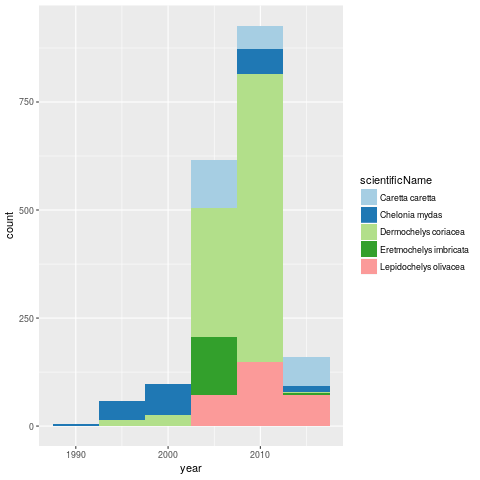

In [8]:
%%R
library(ggplot2)

turtles$year <- as.numeric(format(as.Date(turtles$eventDate), "%Y"))
table(turtles$year)

ggplot() + geom_histogram(
    data=turtles,
    aes(x=year, fill=scientificName),
    binwidth=5) + scale_fill_brewer(palette='Paired')

One would guess that the 2010 count increase would be due to an increase in the sampling effort, but the drop around 2010 seems troublesome. It can be a real threat to these species, or the observation efforts were defunded.


To explore this dataset further we can make use of the `obistools`' R package. `obistools` has many visualization and quality control routines built-in. Here is an example on how to use `plot_map` to quickly visualize the data on a geographic context.

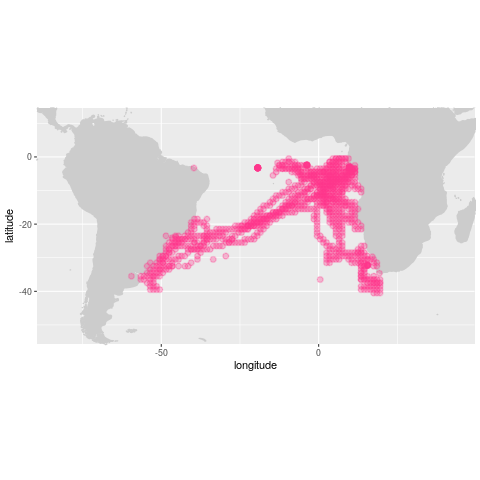

In [9]:
%%R

library(dplyr)

coriacea <- turtles %>% filter(species=='Dermochelys coriacea')
plot_map(coriacea, zoom=TRUE)

However, if we want to create a slightly more elaborate map with clusters and informative pop-ups, can use the python library `folium` instead.

In [10]:
import folium
from pandas import DataFrame

def filter_df(df):
    return df[['lifestage',
               'institutionCode',
               'individualCount',
               'sex',
               'eventDate']]

def make_popup(row):
    classes = ('table table-striped table-hover table-condensed '
               'table-responsive')
    html = DataFrame(row).to_html(classes=classes)
    return folium.Popup(html)

def make_marker(row, popup=None):
    location = row['decimalLatitude'], row['decimalLongitude']
    return folium.Marker(location=location, popup=popup)

In [11]:
turtles['institutionCode'].value_counts()

NA                                                                             900
Projeto TAMAR                                                                  496
IRD, UMR EME, SÃ¨te, France                                                    325
University of Pisa, Italy / Swansea University, UK / und University, Sweden    115
Miguel Morais - Faculdade de Ciências / DEI de Biologia                        110
Brazil Trawl caught turtles                                                     99
Seaturtle.org / UC Santa Cruz / MTRG                                            62
Islameta Group, Dept. of Biology - University of Pisa                           52
Diego Albareda-PRICTMA                                                          45
Diveboard                                                                       37
Univ of Exeter, Wildlife Conservation Society, Stanford Univ, UC Santa Cruz     28
Yonat                                                                           15
AM  

In [12]:
from folium.plugins import MarkerCluster


species_found = sorted(set(turtles['scientificName']))

clusters = {s: MarkerCluster() for s in species_found}
groups = {s: folium.FeatureGroup(name=s) for s in species_found}

In [13]:
def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))

In [14]:
m = folium.Map()

for turtle in species_found:
    df = turtles.loc[turtles['scientificName'] == turtle]
    for k, row in df.iterrows():
        popup = make_popup(filter_df(row))
        make_marker(row, popup=popup).add_to(clusters[turtle])
    clusters[turtle].add_to(groups[turtle])
    groups[turtle].add_to(m)


m.fit_bounds(m.get_bounds())
folium.LayerControl().add_to(m);

In [15]:
embed_map(m)

We can get fancy and use shapely to "merge" the points that are on the ocean and get an idea of migrations routes.

First let's use `obistools` QA/QC functions to eliminate the points that fall on land.

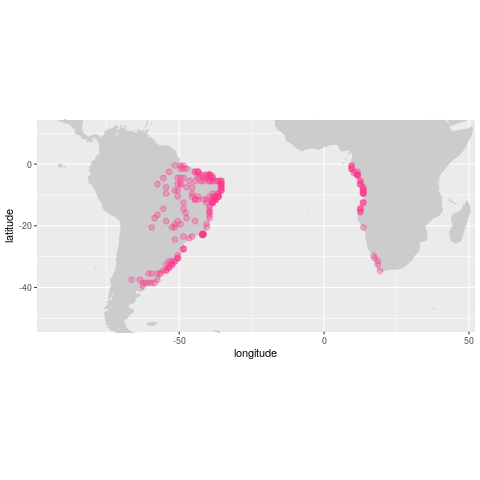

In [16]:
%%R -o land

land <- check_onland(turtles)

plot_map(land, zoom=TRUE)

In [17]:
turtles.set_index('id', inplace=True)
land.set_index('id', inplace=True)

mask = turtles.index.isin(land.index)
ocean = turtles[~mask]

Now we can use shapely's buffer to "connect" the points that are close to each other to visualize a possible migration path.

In [18]:
from palettable.cartocolors.qualitative import Bold_6


colors = {s: c for s, c in zip(species_found, Bold_6.hex_colors)}
style_function = lambda color: (lambda feature: dict(color=color, weight=2, opacity=0.6))

In [19]:
from folium.plugins import Fullscreen
from shapely.geometry import MultiPoint
from shapely.ops import polygonize

m = folium.Map()
Fullscreen().add_to(m)

for turtle in species_found:
    df = ocean.loc[ocean['scientificName'] == turtle]
    positions = MultiPoint(
        list(zip(
            df['decimalLongitude'].values,
            df['decimalLatitude'].values)
            )
    ).buffer(distance=2)
    folium.GeoJson(
        positions.__geo_interface__,
        name=turtle,
        tooltip=turtle,
    style_function=style_function(color=colors[turtle]),
    ).add_to(m)
    
m.fit_bounds(m.get_bounds())
folium.LayerControl().add_to(m);

In [20]:
m

One interesting feature of this map is *Dermochelys coriacea*'s migration between Brazilian and African shores.

More information on [*Dermochelys coriacea*](http://www.iucnredlist.org/details/6494/0) and the other Sea Turtles can be found in the species [IUCN red list](http://www.iucnredlist.org).